# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [141]:
# Import libraries necessary for this project
from __future__ import division
import numpy as np
import pandas as pd
import renders as rs
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [142]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [143]:
# Select three indices to sample from the dataset
np.random.seed(30)
indices = np.random.randint(len(data), size=3)
print(indices)

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

[293 421 429]
Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3996,11103,12469,902,5952,741
1,17063,4847,9053,1031,3415,1784
2,8607,1750,3580,47,84,2501


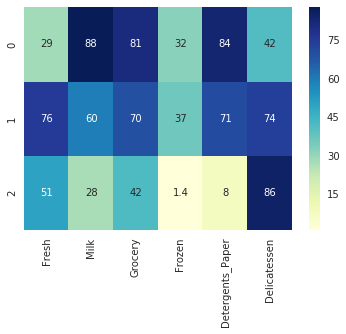

In [144]:
# look at percentile ranks
pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)

# visualize percentiles with heatmap
_ = sns.heatmap(pcts.reset_index(drop=True), annot=True, cmap='YlGnBu')

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**
0. A supermarket with an emphasis on Milk, Groceries, and household supplies (Deter.). 
    - Milk, Groceries, and Detergents_Paper are all in the 4th quantile, while spending on Frozen, Fresh, and Delicatessen are below average.
1. Another supermarket, but with more of an emphasis on fresh produce.
    - Fresh produce is in the 4th quantile, and Milk, Grocery, and Detergents_Paper are above average.
2. A cafe or restaurant, as they purchase mostly fresh goods and groceries.
    - Fresh and Delicatessen are above average, but Frozen, Detergents_Paper, and Milk are all below average.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [145]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
for feature in data.columns:
    
    new_data = data.drop([feature], axis=1)

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], random_state=15)

    # Create a decision tree regressor and fit it to the training set
    reg = DecisionTreeRegressor(random_state=99)
    reg.fit(X_train, y_train)

    prediction = reg.predict(X_test)
    # TODO: Report the score of the prediction using the testing set
    score = r2_score(prediction, y_test)
    print("Feature {} predicted with r^2 of {}".format(feature, score))

Feature Fresh predicted with r^2 of -0.376897876335
Feature Milk predicted with r^2 of 0.231658595619
Feature Grocery predicted with r^2 of 0.729943576323
Feature Frozen predicted with r^2 of -0.00105915100653
Feature Detergents_Paper predicted with r^2 of 0.739151644264
Feature Delicatessen predicted with r^2 of -1.06786730518


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** It looks like "Detergents_Paper" can most accurately be predicted from the other data, with an R^2 of `0.74`. Even though there is a relatively strong correlation, I would argue that this feature still contains useful information in identifying customer spending habits. If the correlation were above `0.90`, I would feel more confident about ommitting it. **It may not be necessary** to identify some general trends, but generally I would not omit this information.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

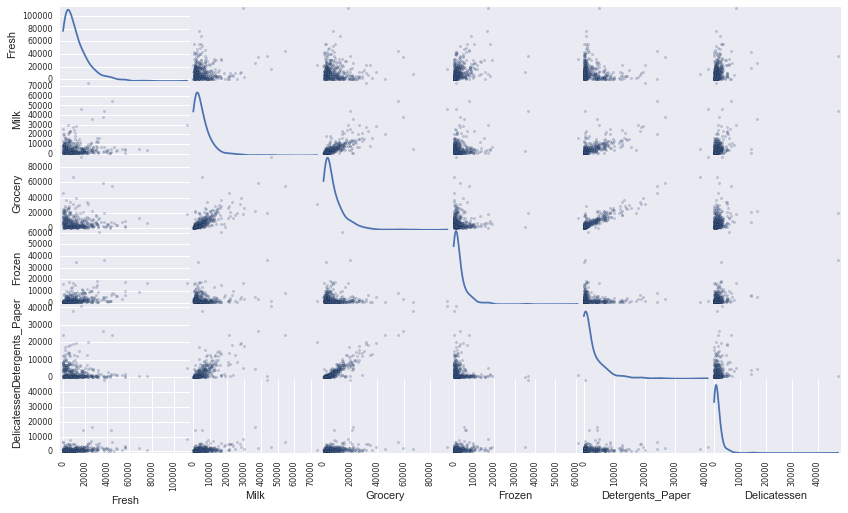

In [146]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

In [147]:
for col in data.columns:
    print("{} has mean {:.2f} and median {:.2f}".format(col, data[col].mean(), data[col].median()))

Fresh has mean 12000.30 and median 8504.00
Milk has mean 5796.27 and median 3627.00
Grocery has mean 7951.28 and median 4755.50
Frozen has mean 3071.93 and median 1526.00
Detergents_Paper has mean 2881.49 and median 816.50
Delicatessen has mean 1524.87 and median 965.50


**Answer:** It looks like there is some correlation between the Grocery and Detegerents_Paper, confirming my suspicion. For each purchase category the mean is greater than the median, indicated a skewed distribution, which is also apparent in the plots. The density of values on the left side, and sparsity of values on the right of each plot suggests they may be log-normally distribution.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

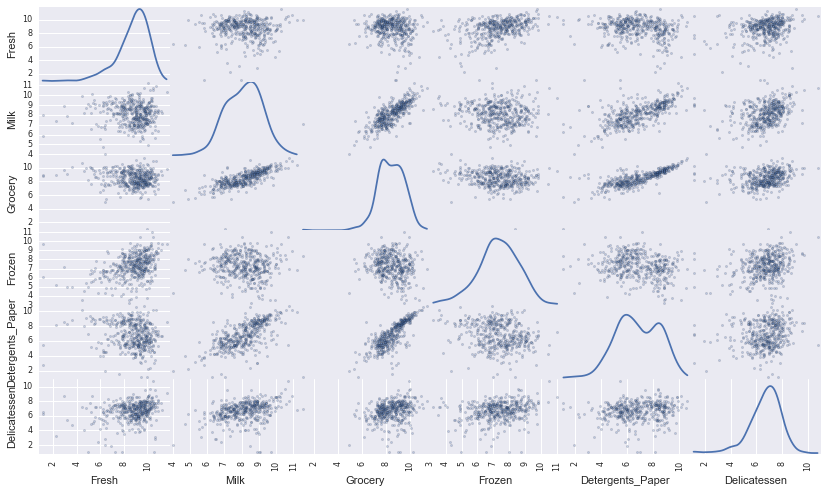

In [148]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [149]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.293049,9.314971,9.431001,6.804615,8.691483,6.608001
1,9.744668,8.486115,9.110851,6.938284,8.135933,7.486613
2,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [150]:
# For each feature find the data points with extreme high or low values
from collections import defaultdict
all_ol = defaultdict(lambda: 0)

for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = log_data[feature].quantile(0.25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = log_data[feature].quantile(0.75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    ol = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(ol)
    for d in ol.index:
        all_ol[d] += 1
        
    
# Select indices which were identified as outliers for more then one category.
outliers  = list(filter(lambda x: all_ol[x] > 1, all_ol))
print("Outliers to be removed: {}".format(outliers))

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Outliers to be removed: [128, 154, 65, 66, 75]


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** Any sample that was seen as an outliers for more then one category was removed. This gives us validity that this sample is an outlier, as it falls outside 1.5 times the IQR for **more then one** of the distributions. Outliers will skew our distribution as well as descriptive statitics like the variance and mean which we rely on for PCA and clustering. Removing outliers prior to PCA allows us to represent as much variance in our data as possible with (as many or) fewer principle components. Outliers, especially samples that are outliers along more then one feature can also skew our cluster centers, which could impact classification of other points.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

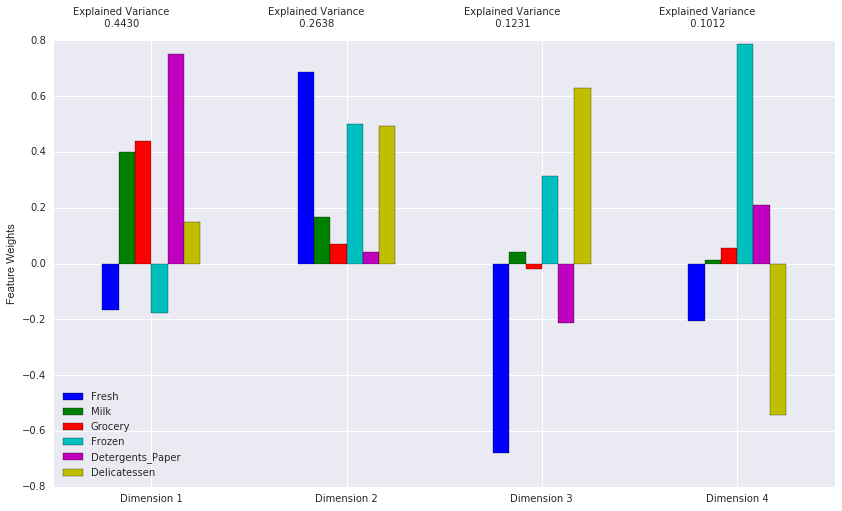

In [151]:
from sklearn.decomposition import PCA

# Apply PCA to the good data with the same number of dimensions as features
pca = PCA(n_components=4)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.fit_transform(good_data)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

In [152]:
print("Cumulative variance explained by components: {}".format(np.cumsum(pca.explained_variance_ratio_) * 100))

Cumulative variance explained by components: [ 44.30250475  70.68172308  82.98810319  93.109011  ]


**Answer:** The first two components explain ~71% of the variance. The first four components explain ~93% of the variance. 
* The first component seems to represent spending in the categories of Milk, Grocery, and Detergents Paper (the negative contributions of Fresh and Frozen are minor). 
* The second component mostly represents spending in the other three categories: Fresh, Frozen, and Delicatessen.
* The third component represents spending on Delicatessen and (more subtly) Frozen, but a lack of spending Fresh and (more subtly) Detergents Paper.
* The fourth component represents spending for Frozen and a little bit of Detergents Paper, and a strong lack of spending for Delicatessen and (more subly) Fresh. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [153]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,1.7580,-0.0097,-0.9590,-1.6824
1,1.7887,0.8123,0.2315,-0.0036
2,1.8834,1.5991,1.3204,-0.5432
3,-1.1553,1.4052,0.5422,0.4127
4,0.7848,2.3943,0.4798,-0.3483
5,1.0850,0.3243,-0.2635,-0.8812
6,1.1286,-0.2629,-1.3162,-0.5369
7,1.5672,0.9010,0.3684,-0.2682
8,0.8636,-0.6650,-0.5376,-0.7922
9,2.8734,0.6774,0.1330,-0.1802


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [154]:
# TODO: Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)

# Apply a PCA transformation the good data
reduced_data = pca.fit_transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_samples = pd.DataFrame(pca_samples, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [155]:
# Display sample log-data after applying PCA transformation in two dimensions
display(np.round(reduced_samples, 4))

,Dimension 1,Dimension 2
0,2.4827,-0.2804
1,1.4571,1.0316
2,-1.4269,-1.2099


In [156]:
print("Variance explained by first component: {:.2f}%".format(pca.explained_variance_ratio_[0] * 100))

Variance explained by first component: 44.30%


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** K-Means is a very interpretable algorithm. It is iterative, and we assign each sample to a cluster with 100% certainty at each iteration. On subsequent iterations we revise these beliefs. Gaussian Mixture Models (GMMS) are similar in that they are iterative, but we don't represent each cluster with certainty, but rather probability distributions (or "soft" clustering). The advantages to this is that we can estimate the confidence that a sample belongs to a given cluster. However, GMMs also have an infinite number of possible configurations, and can reach local minimums which require random restarts. It is also not as scalable as K-Means.

Given that it is likely that some customers may play a role somewhere between a supermarket, and a restaurant, I will use the Gaussian Mixture Model. The uncertainty, and likelyhood a given point has of belonging to each cluster will be useful when identifying customers that belong in either cluster. While K-Means is more scalable, this is not much of a concern here as our dataset is small.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [157]:
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

def build_and_score_clusters(n_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=n_clusters, random_state=30)

    # Predict the cluster for each data point
    preds = clusterer.fit_predict(reduced_data)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("Score for {} clusters: {:.3f}".format(n_clusters, score))
    return clusterer, preds

for i in range(2, 10):
    build_and_score_clusters(i)

Score for 2 clusters: 0.412
Score for 3 clusters: 0.374
Score for 4 clusters: 0.329
Score for 5 clusters: 0.312
Score for 6 clusters: 0.275
Score for 7 clusters: 0.324
Score for 8 clusters: 0.308
Score for 9 clusters: 0.315


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** It appears as though 2 clusters gives the best silhouette score (0.412), as the score decreases with increasing clusters after that.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

In [158]:
clusterer, preds = build_and_score_clusters(2)
# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(reduced_samples)

Score for 2 clusters: 0.412


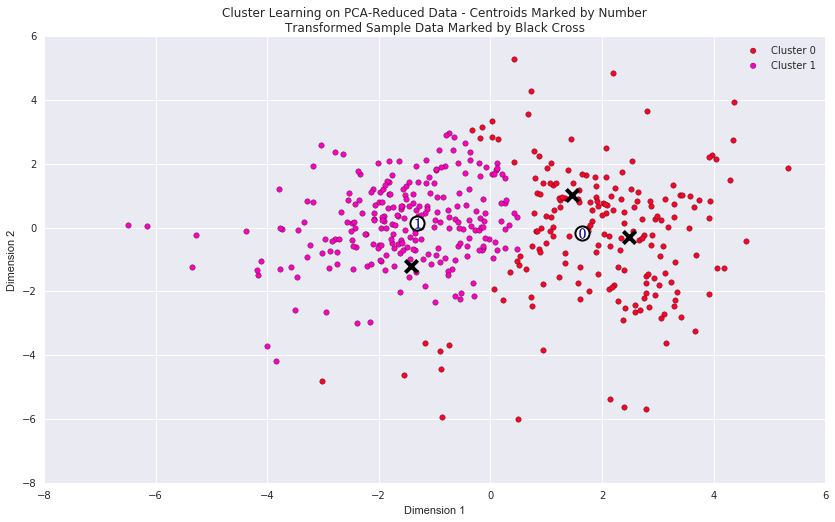

In [159]:
# Display the results of the clustering from implementation
centers = clusterer.means_
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 1,4316,6347,9555,1036,3046,945
Segment 2,8812,2052,2689,2058,337,712


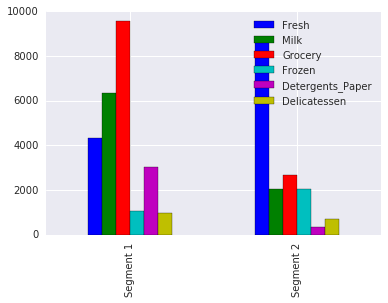

In [160]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i + 1) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
true_centers.plot(kind = 'bar')

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

In [161]:
# Uncomment to see descriptive statistics
display(data.describe()) 

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Answer:** 
* Cluster center one could potentially be more of a supermarket, as they likely sell more frozen food, house hold supplies (Detergents_Paper) and more groceries. For these customers, `Detergent`, `Milk`, and `Grocery` spending fall in the third quantile. However, spending on `Fresh` goods is below average, and `Delicatessen` is also close to average.
* Cluster center two could represent cafes or restaurants that require mainly fresh produce and delicatessen. The quantity of spending in the `Fresh` category falls into the 3rd quantile, while spending in the `Delicatessen` category falls inside the 4th quantile. However, `Frozen`, and `Detergent` spending of these customers are low, and fall into the first and second quantile, respectively.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [164]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i + 1, "predicted to be in Cluster", pred + 1

Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1
Sample point 3 predicted to be in Cluster 2


**Answer:** Samples 1 and 2 both cluster with our "supermarket" category, as we initially predicted. Sample 3 falls into the cafe or restaurant category, as they require more fresh produce and delicatessen. Our predictions were correct!

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:** If the distributers decided to test 3-day delivery on a group of customers, I would suggest cluster two, or our "supermarket" category. These customers require less fresh goods and delicatessen, which have a shorter shelf-life. The deliveries could instead deliver a higher quanitity each, to keep the volume of goods delivered constant. We would want to test these two groups idependently, as they may respond differently due to the shelf-life of their purchases.

We could randomly assign customers we identified as supermarkets into two groups, one which recieves the new delivery schedule, and one which does not. We could then identify whether or not the delivery changes were cost effective, and how they were recieved by customers. The same approach could then be used with the restaurant category.

### Question 11
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:** We could add a label for the cluster to the dataset, and assign every data point to its corresponding cluster (as predicted by our Gaussian Mixture Model). We could then train a supervised learning algorithm, which would eventualy allow the distributer to make predictions on which group a new customer belongs to, based on their spending.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

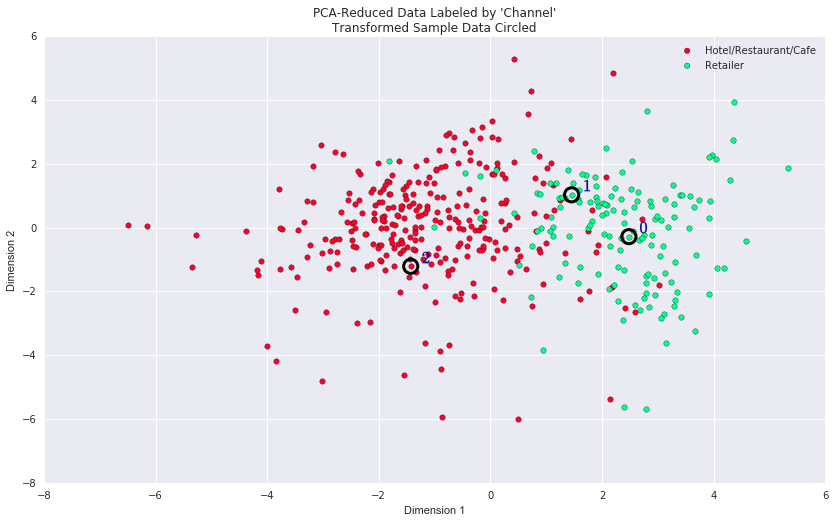

In [163]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** I chose two clusters, which aligns with the two seperate customer categories of 'Retailers' or 'HoReCa'. It is evident from our PCA analysis that there categories are distinct based on spending in the six categories we looked at. My initial prediction appears to be correct! It seems like 'HoReCa' purchase a high amount of Fresh goods and Delicatessen, whereas 'Retailers' tend to purchase more in the 'Milk', 'Grocery', and 'Detergents Paper' categories.

From the plot above it is clear that there are still several outliers. Some 'HoReCa' have spending patterns like 'Retailer' consumers – as they lie close to the cluster center of the opposite category. The same is true for some 'Retailer' consumers. Furthermore, some consumers fall in approximately between the two clusters. These customers may serve both the functionality of a 'Retailer' and 'HoReCa'. We can expect to have some outliers in our data – what is important is that there is a reconizable pattern amongst the data – the majority of consumers cluster well together.